**Import required libraries and scripts**

In [164]:
#Import required libraries and scripts
from scripts.library_preparation import *
from scripts.utilities import *
from scripts.docking_functions import *
from scripts.clustering_functions import *
from scripts.rescoring_functions import *
from scripts.consensus_methods import *
from scripts.performance_calculation import *
from scripts.dogsitescorer import *
from scripts.get_pocket import *

### Data input, then create each path 
- suitable for every machine

In [165]:
protein_name = 'protein_protoss_noligand.pdb'
ligand_library = 'ecft_scores_new_cleaned.sdf'
reference_ligand = 'ref_ligand.sdf'

### Global Path for every local machine

In [166]:
HERE = Path(_dh[-1])
DATA = (HERE / "data")


# Move input data (protein pdb, docking library and reference ligand) to data directory
software = str(HERE / "software")
protein_file = str(DATA / 'A' / protein_name)
docking_library = str(DATA / 'A' / ligand_library)
ref_file = str(DATA / 'A' /reference_ligand)

### DockM8 config

In [167]:
pocket = 'reference'
protonation = 'pkasolver'
docking_programs = ['GNINA', 'SMINA', 'PLANTS']
clustering_metrics = ['RMSD', 'spyRMSD', 'espsim', 'bestpose', 'bestpose_PLANTS', 'bestpose_GNINA', 'bestpose_SMINA']
clustering_method = 'KMedoids'
rescoring= ['gnina', 'AD4', 'chemplp', 'rfscorevs', 'LinF9', 'RTMScore', 'vinardo', 'SCORCH']
id_column = 'ID'
n_poses = 10
exhaustiveness = 8
ncpus = 14
#Create a temporary folder for all further calculations
w_dir = DATA
print('The working directory has been set to:', w_dir)
(DATA/'temp').mkdir(exist_ok=True)

The working directory has been set to: /home/ibrahim/Github/ECFT-VS-pipeline/data


In [168]:
# if os.path.isfile(protein_file.replace('.pdb', '_pocket.pdb')) == False:
if pocket == 'reference':
    pocket_definition = get_pocket(ref_file, protein_file, 8)
    print(pocket_definition)
elif pocket == 'dogsitescorer':
    pocket_definition = binding_site_coordinates_dogsitescorer(protein_file, w_dir, method='volume')


[2023-Aug-03 15:53:33]: Extracting pocket from /home/ibrahim/Github/ECFT-VS-pipeline/data/A/protein_protoss_noligand.pdb using /home/ibrahim/Github/ECFT-VS-pipeline/data/A/ref_ligand.sdf as reference ligand

[2023-Aug-03 15:53:50]: Finished extracting pocket from /home/ibrahim/Github/ECFT-VS-pipeline/data/A/protein_protoss_noligand.pdb using /home/ibrahim/Github/ECFT-VS-pipeline/data/A/ref_ligand.sdf as reference ligand
{'center': [67.84, 79.11, 89.67], 'size': [16.0, 16.0, 16.0]}


In [6]:
if os.path.isfile(w_dir / 'temp' / 'final_library.sdf') == False:
    prepare_library(docking_library, id_column, protonation, ncpus)

In [7]:
docking(w_dir, protein_file, pocket_definition, docking_programs, exhaustiveness, n_poses, ncpus)


[2023-Aug-03 10:56:26]: Split final library folder already exists...


In [8]:
concat_all_poses(w_dir, docking_programs)


[2023-Aug-03 10:56:30]: All poses succesfully combined!


In [9]:
print('Loading all poses SDF file...')
tic = time.perf_counter()
all_poses = PandasTools.LoadSDF(str(w_dir / 'temp' / 'allposes.sdf'), idName='Pose ID', molColName='Molecule', includeFingerprints=False, strictParsing=True)
toc = time.perf_counter()
print(f'Finished loading all poses SDF in {toc-tic:0.4f}!...')

Loading all poses SDF file...


Finished loading all poses SDF in 2.8758!...


In [10]:
# for metric in clustering_metrics:
#         if os.path.isfile(str(w_dir)+f'/temp/clustering/{metric}_clustered.sdf') == False:
#             cluster_pebble(metric, 'KMedoids', w_dir, protein_file, all_poses, ncpus)

In [11]:
rescore_all(w_dir, protein_file, pocket_definition, (w_dir / 'temp' / "allposes.sdf"), rescoring, ncpus)


[2023-Aug-03 10:56:33]: Skipping gnina rescoring...

[2023-Aug-03 10:56:33]: Skipping AD4 rescoring...

[2023-Aug-03 10:56:33]: Skipping chemplp rescoring...

[2023-Aug-03 10:56:33]: Skipping rfscorevs rescoring...

[2023-Aug-03 10:56:33]: Skipping LinF9 rescoring...

[2023-Aug-03 10:56:33]: Skipping RTMScore rescoring...

[2023-Aug-03 10:56:33]: Skipping vinardo rescoring...

[2023-Aug-03 10:56:33]: Skipping SCORCH rescoring...

[2023-Aug-03 10:56:33]: Rescoring complete in 0.0011!


### Load all scores calculated

In [153]:
# df_rescored = pd.read_csv('data/temp/rescoring_allposes/allposes_rescored.csv')
# display(df_rescored.dropna(axis=1))    
# df_rtm_scores = pd.read_csv('data/temp/rescoring_allposes/RTMScore_rescoring/RTMScore_scores.csv')
# df_rtm_scores['Pose ID'] = df_rtm_scores['Pose ID'].apply(lambda x: x.split('-')[0])
# df_merged = pd.merge(df_rescored, df_rtm_scores, on='Pose ID', how='left')
# df_merged.rename(columns={'CHEMPLP_x': 'CHEMPLP'}, inplace=True)
# df_merged.dropna(axis=1, inplace=True)
# df_merged.to_csv('data/temp/rescoring_allposes/allposes_rescored_cleaned.csv', index=False)

In [169]:
df_rescored = pd.read_csv('data/temp/rescoring_allposes/allposes_rescored_cleaned.csv')
df_rescored.dropna(axis=1)

df_scores = PandasTools.LoadSDF('data/ligands/ecft_scores_new_cleaned.sdf')
# df_rescored['ID'] = df_rescored['Pose ID'].str.split('_').str[0]
# make all columns that have numbers numeric and ignore error if there are strings
df_rescored = df_rescored.apply(pd.to_numeric, errors='ignore')

#select important columns
selected_columns = df_rescored.columns[1:].tolist()

#prepare input data
df_rescored_copy = df_rescored.copy()
df_rescored_copy['ID'] = df_rescored_copy['Pose ID'].apply(lambda x: x.split('_')[0])
df_rescored_copy = df_rescored_copy.drop('Pose ID', axis=1)
display(df_rescored)

,Pose ID,CHEMPLP,AD4,LinF9,RFScoreVS,Vinardo,SCORCH,GNINA_Affinity,CNN-Score,CNN-Affinity,RTMScore
0,HIPS6708_GNINA_10,-42.3940,-24.78419,-5.42890,5.961558,-5.23439,0.04540,-6.21264,0.383994,4.186918,5.544686
1,HIPS5964_GNINA_2,-46.7396,-14.61920,-3.13817,5.952688,-4.00279,0.01967,-3.69976,0.812844,4.219968,5.394657
2,HIPS6785_GNINA_4,-36.5144,-26.76097,-5.28858,5.959136,-3.91180,0.03101,-5.85308,0.451291,4.232083,6.781636
3,HIPS6785_GNINA_8,-53.1567,-27.77722,-5.31034,5.980354,-3.95434,0.01035,-6.07650,0.412702,4.235092,5.979020
4,HIPS5964_GNINA_6,-39.8885,-16.43842,-3.29266,5.950000,-2.98909,0.00680,-3.94788,0.780733,4.265656,1.525102
...,...,...,...,...,...,...,...,...,...,...,...
6325,HIPS407_PLANTS_6,-79.9792,-34.68678,-6.73597,5.966049,-5.68300,0.00571,-6.18394,0.338705,6.588778,4.475529
6326,HIPS407_PLANTS_7,-81.4229,-30.78702,-6.30059,5.970802,-4.81556,0.10666,-6.21485,0.357839,6.561721,4.118472
6327,HIPS407_PLANTS_8,-80.7767,-34.50039,-6.92272,5.970749,-7.16310,0.02425,-6.95213,0.199590,6.291203,6.002588
6328,HIPS407_PLANTS_9,-79.6303,-31.43524,-6.36249,5.964186,-5.97280,0.00545,-6.26000,0.133258,6.517162,5.030889


### Calculate different consensus ranking

In [170]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scripts.consensus_methods import *


def map_correlation(df):
    method = " ".join(df.columns[1].split('_')[0:-1])
    df = df.apply(pd.to_numeric, errors='ignore')
    correlation = df.iloc[:, 1].corr(df.iloc[:, 2])
    spearmanr_corr, p_value = spearmanr(df.iloc[:, 1], df.iloc[:, 2])

    # Plot
    plt.scatter(df.iloc[:, 1], df.iloc[:, 2])
    plt.title(f'{method} vs. calculated scores\n correlation = {correlation} \n spearmanr = {spearmanr_corr}')
    plt.xlabel(method)
    plt.ylabel('Scores')
    plt.show()

,CHEMPLP,AD4,LinF9,RFScoreVS,Vinardo,SCORCH,GNINA_Affinity,CNN-Score,CNN-Affinity,RTMScore,ID
0,-42.3940,-24.78419,-5.42890,5.961558,-5.23439,0.04540,-6.21264,0.383994,4.186918,5.544686,HIPS6708
1,-46.7396,-14.61920,-3.13817,5.952688,-4.00279,0.01967,-3.69976,0.812844,4.219968,5.394657,HIPS5964
2,-36.5144,-26.76097,-5.28858,5.959136,-3.91180,0.03101,-5.85308,0.451291,4.232083,6.781636,HIPS6785
3,-53.1567,-27.77722,-5.31034,5.980354,-3.95434,0.01035,-6.07650,0.412702,4.235092,5.979020,HIPS6785
4,-39.8885,-16.43842,-3.29266,5.950000,-2.98909,0.00680,-3.94788,0.780733,4.265656,1.525102,HIPS5964
...,...,...,...,...,...,...,...,...,...,...,...
6325,-79.9792,-34.68678,-6.73597,5.966049,-5.68300,0.00571,-6.18394,0.338705,6.588778,4.475529,HIPS407
6326,-81.4229,-30.78702,-6.30059,5.970802,-4.81556,0.10666,-6.21485,0.357839,6.561721,4.118472,HIPS407
6327,-80.7767,-34.50039,-6.92272,5.970749,-7.16310,0.02425,-6.95213,0.199590,6.291203,6.002588,HIPS407
6328,-79.6303,-31.43524,-6.36249,5.964186,-5.97280,0.00545,-6.26000,0.133258,6.517162,5.030889,HIPS407


,CHEMPLP,AD4,LinF9,RFScoreVS,Vinardo,SCORCH,GNINA_Affinity,CNN-Score,CNN-Affinity,RTMScore,ID
0,1.143331,1.081455,1.017301,0.981340,1.016676,0.999857,1.019823,0.998787,0.986858,0.982634,HIPS6708
1,1.159138,1.047274,1.009965,0.981368,1.012727,0.999938,1.011758,0.997435,0.986755,0.983100,HIPS5964
2,1.122288,1.088230,1.016850,0.981348,1.012436,0.999902,1.018665,0.998575,0.986717,0.978801,HIPS6785
3,1.182879,1.091730,1.016920,0.981282,1.012572,0.999967,1.019385,0.998697,0.986708,0.981286,HIPS6785
4,1.134316,1.053311,1.010458,0.981376,1.009489,0.999979,1.012552,0.997536,0.986613,0.995193,HIPS5964
...,...,...,...,...,...,...,...,...,...,...,...
6325,1.287496,1.115826,1.021511,0.981326,1.018118,0.999982,1.019731,0.998930,0.979398,0.985959,HIPS407
6326,1.293382,1.102162,1.020107,0.981312,1.015331,0.999663,1.019830,0.998870,0.979481,0.987072,HIPS407
6327,1.290744,1.115169,1.022114,0.981312,1.022890,0.999923,1.022209,0.999370,0.980319,0.981213,HIPS407
6328,1.286077,1.104421,1.020306,0.981332,1.019051,0.999983,1.019976,0.999579,0.979619,0.984230,HIPS407


,CHEMPLP,AD4,LinF9,RFScoreVS,Vinardo,SCORCH,GNINA_Affinity,CNN-Score,CNN-Affinity,RTMScore,ID,Method1_ECR_allposes
0,1.143331,1.081455,1.017301,0.981340,1.016676,0.999857,1.019823,0.998787,0.986858,0.982634,HIPS6708,0.032316
1,1.159138,1.047274,1.009965,0.981368,1.012727,0.999938,1.011758,0.997435,0.986755,0.983100,HIPS5964,0.032194
2,1.122288,1.088230,1.016850,0.981348,1.012436,0.999902,1.018665,0.998575,0.986717,0.978801,HIPS6785,0.032240
3,1.182879,1.091730,1.016920,0.981282,1.012572,0.999967,1.019385,0.998697,0.986708,0.981286,HIPS6785,0.032453
4,1.134316,1.053311,1.010458,0.981376,1.009489,0.999979,1.012552,0.997536,0.986613,0.995193,HIPS5964,0.032167
...,...,...,...,...,...,...,...,...,...,...,...,...
6325,1.287496,1.115826,1.021511,0.981326,1.018118,0.999982,1.019731,0.998930,0.979398,0.985959,HIPS407,0.032886
6326,1.293382,1.102162,1.020107,0.981312,1.015331,0.999663,1.019830,0.998870,0.979481,0.987072,HIPS407,0.032851
6327,1.290744,1.115169,1.022114,0.981312,1.022890,0.999923,1.022209,0.999370,0.980319,0.981213,HIPS407,0.032908
6328,1.286077,1.104421,1.020306,0.981332,1.019051,0.999983,1.019976,0.999579,0.979619,0.984230,HIPS407,0.032842


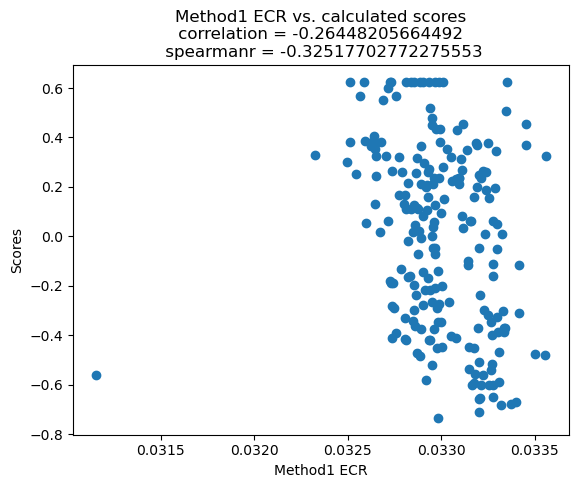

In [203]:
def method1_ECR_best(df, clustering_metric, selected_columns):
    '''
    A method that calculates the ECR (Exponential Consensus Ranking) score for each ID in the rescored dataframe and returns the ID for the pose with the best ECR rank.
    '''
    sigma = 0.05 * len(df)
    print(len(df))
    df = df.apply(lambda x: (np.exp(-(x / sigma)) / sigma) *
                  1000 if x.name in selected_columns else x)
    df[f'Method1_ECR_{clustering_metric}'] = df.sum(axis=0, numeric_only=True)
    df = df.drop(selected_columns, axis=1)
    # Aggregate rows using best ECR per ID
    df2 = df.sort_values(
        f'Method1_ECR_{clustering_metric}',
        ascending=False).drop_duplicates(
        ['ID'])
    return df2[['ID', f'Method1_ECR_{clustering_metric}']]
    
df_method1_ecr_best = method1_ECR_best(df_rescored_copy, 'allposes', selected_columns).merge(df_scores, on='ID')
map_correlation(df_method1_ecr_best)

In [179]:
l = [4,5]
sigma = 0.05 * 
[np.exp(-(x / sigma))  for x in l]

[1.8048513878454153e-35, 3.720075976020836e-44]

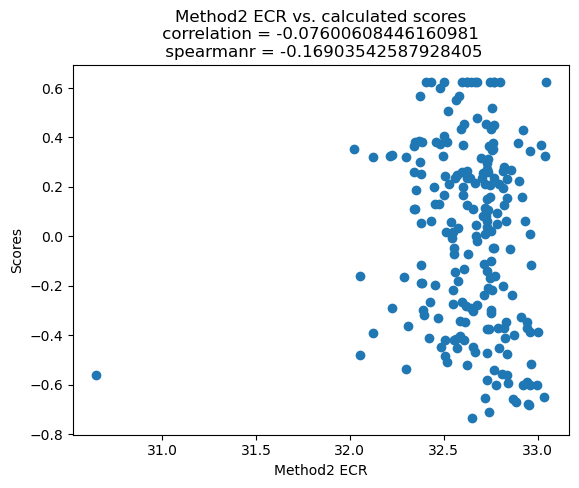

In [157]:
df_method2_ecr_avg = method2_ECR_average(df_rescored_copy, 'allposes', selected_columns).merge(df_scores, on='ID')
map_correlation(df_method2_ecr_avg)

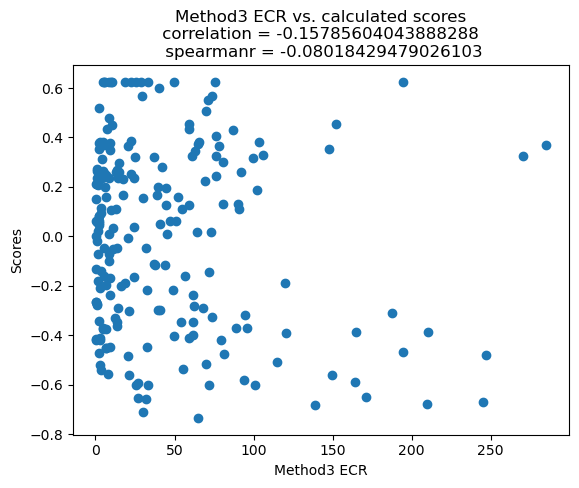

In [158]:
df_method3_avg_ecr = method3_avg_ECR(df_rescored_copy, 'allposes', selected_columns).merge(df_scores, on='ID')
map_correlation(df_method3_avg_ecr)

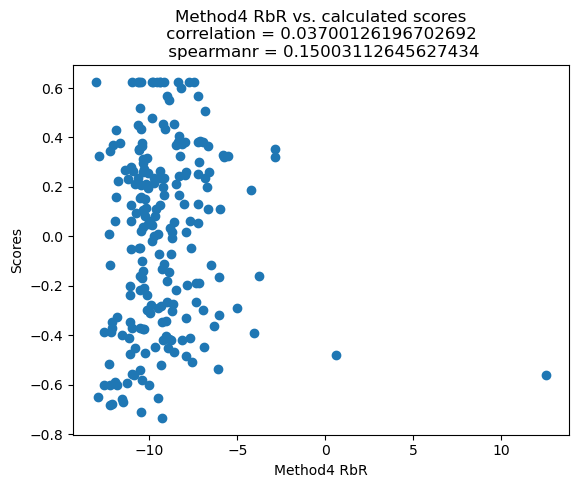

In [159]:
df_method4_rbr = method4_RbR(df_rescored_copy, 'allposes', selected_columns).merge(df_scores, on='ID')
map_correlation(df_method4_rbr)

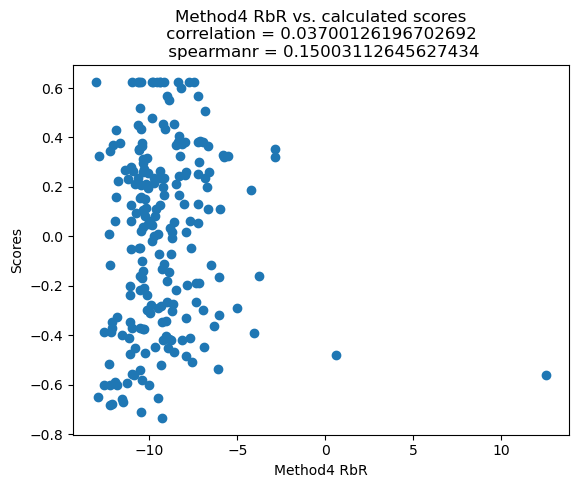

In [160]:
df_method5_rbv = method5_RbV(df_rescored_copy, 'allposes', selected_columns).merge(df_scores, on='ID')
map_correlation(df_method4_rbr)

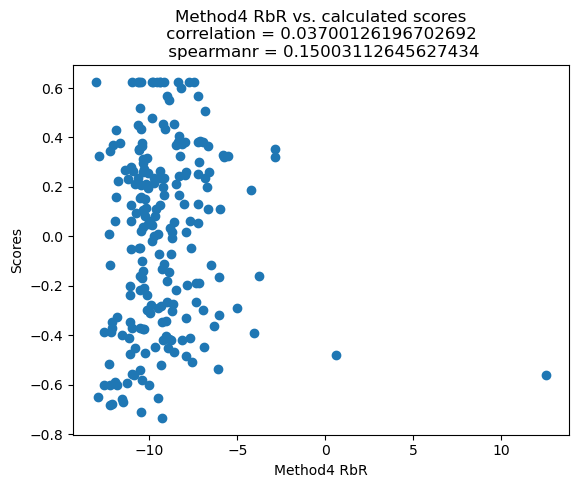

In [161]:
df_method6_Zscore = method6_Zscore_best(df_rescored_copy, 'allposes', selected_columns).merge(df_scores, on='ID')
map_correlation(df_method4_rbr)

# DiffDock is plugged to DockM8 and rescored

In [26]:
# rescore_all(w_dir, protein_file, pocket_definition, (w_dir / 'temp' / 'diffdock' / "diffdock_poses.sdf"), rescoring, 1)


[2023-Aug-03 11:01:18]: Skipping gnina rescoring...

[2023-Aug-03 11:01:18]: Skipping AD4 rescoring...

[2023-Aug-03 11:01:18]: Skipping chemplp rescoring...

[2023-Aug-03 11:01:18]: Skipping rfscorevs rescoring...

[2023-Aug-03 11:01:18]: Skipping LinF9 rescoring...

[2023-Aug-03 11:01:18]: Skipping RTMScore rescoring...

[2023-Aug-03 11:01:18]: Skipping vinardo rescoring...

[2023-Aug-03 11:01:18]: Skipping SCORCH rescoring...

[2023-Aug-03 11:01:18]: Combining all scores for /home/ibrahim/Github/ECFT-VS-pipeline/data/temp/rescoring_diffdock_poses


Combining scores: 100%|██████████| 7/7 [00:00<00:00, 688.59files/s]


[2023-Aug-03 11:01:18]: Rescoring complete in 0.0293!


In [78]:
# merged_df = pd.read_csv('data/temp/rescoring_diffdock_poses/AD4_rescoring/AD4_scores.csv')
# for file in os.listdir('data/temp/rescoring_diffdock_poses/'):
#     scoring_method = file.split('_')[0]
#     df = pd.read_csv(f'data/temp/rescoring_diffdock_poses/{file}/{scoring_method}_scores.csv')
#     #merge on Pose ID the two dataframes
#     merged_df = pd.merge(merged_df, df, on='Pose ID', how='outer')

# # add _diffdock_1 to Pose ID
# merged_df['Pose ID'] = merged_df['Pose ID'].apply(lambda x: x + '_diffdock_1')

# merged_df.to_csv('data/temp/rescoring_diffdock_poses/diffdock_rescoring.csv', index=False)


In [89]:
# diffdock_rescored_df = pd.read_csv('data/temp/rescoring_diffdock_poses/diffdock_rescoring.csv').drop(['AD4_y', 'confidence_score', 'score'], axis=1).set_index('Pose ID')
# diffdock_rescored_df = diffdock_rescored_df.rename(columns={'AD4_x': 'AD4'})
# allposes_rescored_df = pd.read_csv('data/temp/rescoring_allposes/allposes_rescored_cleaned.csv').set_index('Pose ID')

# df_diffdock_rescored = pd.concat([diffdock_rescored_df, allposes_rescored_df], ignore_index=False)
# df_diffdock_rescored.to_csv('data/temp/rescoring_diffdock_poses/allposes_diffdock_rescored_cleaned.csv')

In [162]:
df_diffdock_rescored = pd.read_csv('data/temp/rescoring_diffdock_poses/allposes_diffdock_rescored_cleaned.csv')

df_scores = PandasTools.LoadSDF('data/ligands/ecft_scores_new_cleaned.sdf')
# df_rescored['ID'] = df_rescored['Pose ID'].str.split('_').str[0]
# make all columns that have numbers numeric and ignore error if there are strings
df_rescored = df_rescored.apply(pd.to_numeric, errors='ignore')

#select important columns
selected_columns = df_rescored.columns[1:].tolist()

#prepare input data
df_diffdock_rescored_copy = df_diffdock_rescored.copy()
df_diffdock_rescored_copy['ID'] = df_diffdock_rescored_copy['Pose ID'].apply(lambda x: x.split('_')[0])
df_diffdock_rescored_copy = df_diffdock_rescored_copy.drop('Pose ID', axis=1)

df_diffdock_rescored_copy

,AD4,CHEMPLP,RTMScore,LinF9,RFScoreVS,Vinardo,SCORCH,GNINA_Affinity,CNN-Score,CNN-Affinity,ID
0,384.56778,151.5520,2.666288,15.90205,6.151677,66.03066,0.00007,58.61554,0.024996,4.375850,HIPS470
1,429.04214,-60.6608,1.864097,16.39047,6.048889,66.46529,0.00035,55.21563,0.020594,3.799256,HIPS7124
2,436.89093,194.1190,2.078524,17.81467,6.074264,70.55367,0.00007,51.41957,0.021230,4.426792,HIPS6415
3,271.72058,-37.6678,2.141810,6.90373,5.960648,34.60669,0.00035,28.21269,0.125711,4.030859,HIPS6795
4,385.25589,-55.3215,4.004877,18.21083,6.019242,69.40868,0.00002,56.51248,0.118553,3.681566,HIPS5024
...,...,...,...,...,...,...,...,...,...,...,...
6537,-34.68678,-79.9792,4.475529,-6.73597,5.966049,-5.68300,0.00571,-6.18394,0.338705,6.588778,HIPS407
6538,-30.78702,-81.4229,4.118472,-6.30059,5.970802,-4.81556,0.10666,-6.21485,0.357839,6.561721,HIPS407
6539,-34.50039,-80.7767,6.002588,-6.92272,5.970749,-7.16310,0.02425,-6.95213,0.199590,6.291203,HIPS407
6540,-31.43524,-79.6303,5.030889,-6.36249,5.964186,-5.97280,0.00545,-6.26000,0.133258,6.517162,HIPS407


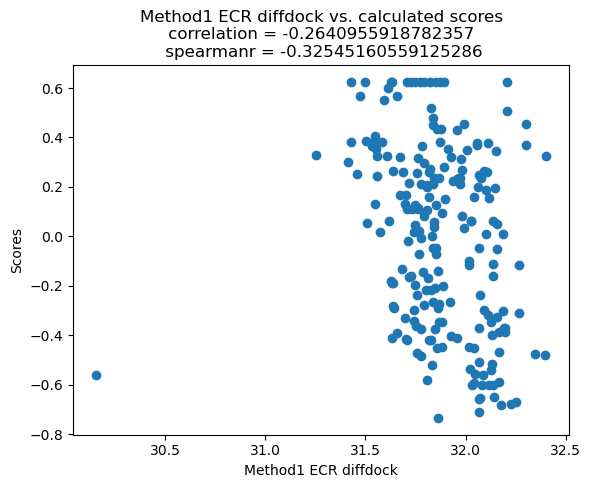

In [163]:
df_method1_ecr_best_diffdock = method1_ECR_best(df_diffdock_rescored_copy, 'diffdock_poses', selected_columns).merge(df_scores, on='ID')
map_correlation(df_method1_ecr_best_diffdock)

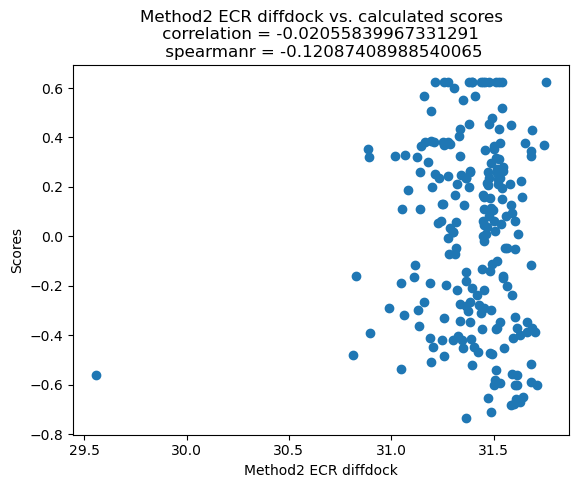

In [140]:
df_method2_ecr_average_diffdock = method2_ECR_average(df_diffdock_rescored_copy, 'diffdock_poses', selected_columns).merge(df_scores, on='ID')
map_correlation(df_method2_ecr_average_diffdock)

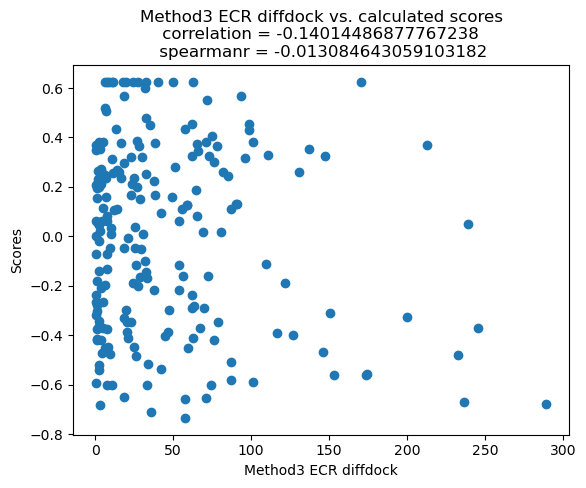

In [141]:
df_method3_avg_ecr_diffdock = method3_avg_ECR(df_diffdock_rescored_copy, 'diffdock_poses', selected_columns).merge(df_scores, on='ID')
map_correlation(df_method3_avg_ecr_diffdock)

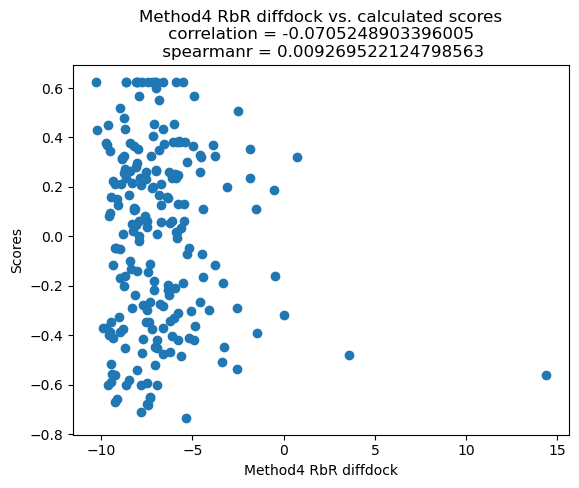

In [142]:
df_method4_rbr_diffdock = method4_RbR(df_diffdock_rescored_copy, 'diffdock_poses', selected_columns).merge(df_scores, on='ID')
map_correlation(df_method4_rbr_diffdock)

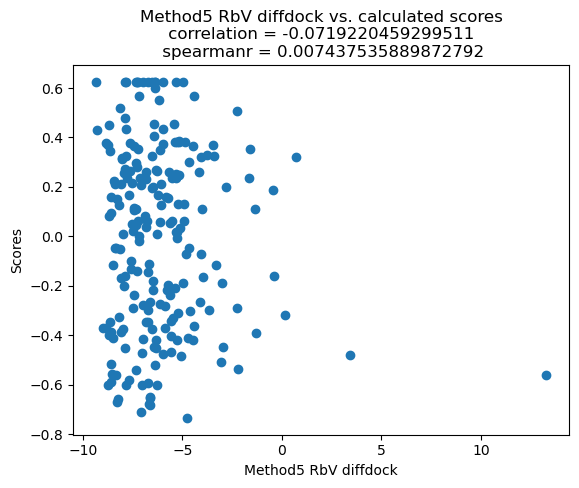

In [143]:
df_method5_rbv_diffdock = method5_RbV(df_diffdock_rescored_copy, 'diffdock_poses', selected_columns).merge(df_scores, on='ID')
map_correlation(df_method5_rbv_diffdock)

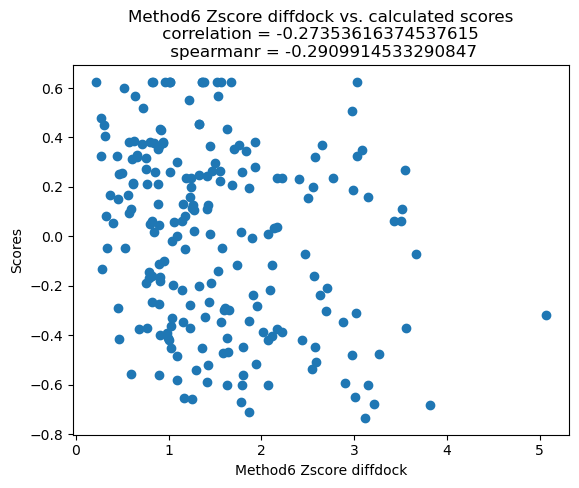

In [144]:
df_method6_Zscore_diffdock = method6_Zscore_best(df_diffdock_rescored_copy, 'diffdock_poses', selected_columns).merge(df_scores, on='ID')
map_correlation(df_method6_Zscore_diffdock)

### Ignore clustering

In [21]:
# for metric in clustering_metrics:
#         rescore_all(w_dir, protein_file, pocket_definition, (w_dir / 'temp' / f'clustering/{metric}_clustered.sdf'), rescoring, ncpus)

In [22]:
# calculate_EF_single_functions(w_dir, docking_library, clustering_metrics)

In [23]:
# apply_consensus_methods_combinations(w_dir, docking_library, clustering_metrics)

In [24]:
# apply_consensus_methods(w_dir, 'bestpose', 'method6', ['gnina', 'RTMScore'])